In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from skimage.color import label2rgb
from skimage.io import imread, imsave
from skimage.measure import label
from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
import elf.segmentation as eseg
from elf.segmentation.utils import normalize_input

plt.rcParams['figure.figsize'] = (10, 10)
import re

In [2]:
def get_frame_n(fname, regexp):
    result = re.findall(regexp, fname)
    assert len(result) == 1
    return int(result[0])

In [3]:
get_frame_n("F107A1_additional_boundaries_0231.tiff", r"\d{4}")

231

In [4]:
result = re.findall(r"\d{4}", "F107A1_additional_boundaries_0231.tiff" )

In [5]:
print(result)

['0231']


In [6]:
segmentation_dir = Path("/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310")
segmentation_files = sorted(list(segmentation_dir.glob("*.tiff")))
raw_dir = Path("/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_raw")
raw_files = sorted(list(raw_dir.glob("*.tiff")))
raw_files = [im_f for im_f in raw_files if (get_frame_n(im_f.name, r"\d{4}") in range(280, 311))]

print(segmentation_files, raw_files)

segmentations = [imread(fname) for fname in segmentation_files]
raw = [imread(fname) for fname in raw_files]


output_dir = Path("/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/") / "280_311_corrected"
output_dir.mkdir(exist_ok=True)

[PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0280.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0281.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0282.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0283.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0284.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0285.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional_boundaries_0286.tiff'), PosixPath('/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_310/F107A1_additional

In [7]:
def get_background_mask(segm, img):
    # Find out of sample part
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    return bg

In [8]:
def get_zero_component(img: np.ndarray):
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    fg = (bg != bg_ind)
    return fg


def get_fg_mask(raw: np.ndarray):
    print("Compute foreground mask")
    print("Raw data shape: ", raw.shape)
    fg_mask = np.array([get_zero_component(img) for img in raw])
    return fg_mask


def run_multicut(ws, boundaries, beta=0.5):
    rag = eseg.compute_rag(ws, n_threads=8)
    features = eseg.compute_boundary_mean_and_length(rag, boundaries, n_threads=8)
    bg_edges = (rag.uvIds() == 0).any(axis=1)
    z_edges = eseg.features.compute_z_edge_mask(rag, ws)
    costs, edge_sizes = features[:, 0], features[:, -1]
    costs = eseg.compute_edge_costs(
        costs, edge_sizes=edge_sizes, weighting_scheme="xyz", z_edge_mask=z_edges, beta=beta
    )
    # set all the weights to the background to be maximally repulsive
    assert len(bg_edges) == len(costs)
    costs[bg_edges] = -2 * np.max(np.abs(costs))
    node_labels = eseg.multicut.multicut_kernighan_lin(rag, costs)
    seg = eseg.project_node_labels_to_pixels(rag, node_labels, n_threads=8)
    return seg

In [9]:
raw = np.array(raw)
segmentations = np.array(segmentations)[:, :, 0:-1]

In [10]:
segmentations

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [11]:
fg_mask = get_fg_mask(raw)

Compute foreground mask
Raw data shape:  (31, 1506, 1647)


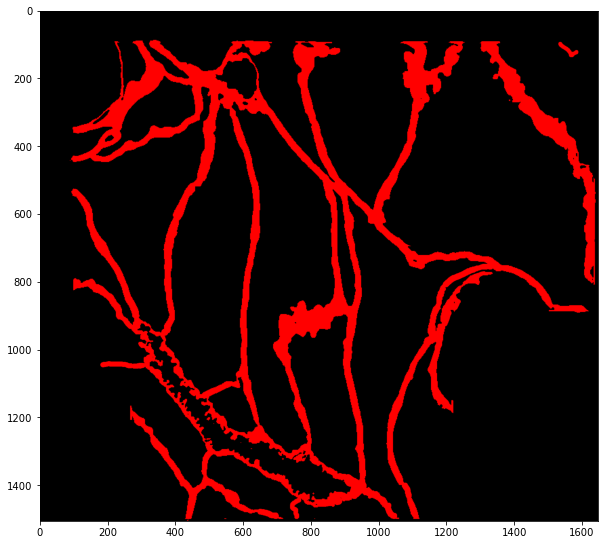

In [12]:
plt.imshow(label2rgb(segmentations[0, ...]))

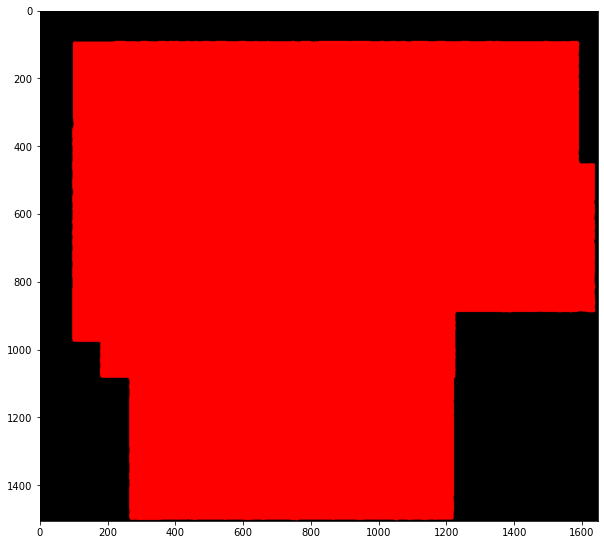

In [13]:
plt.imshow(label2rgb(fg_mask[0, ...]))

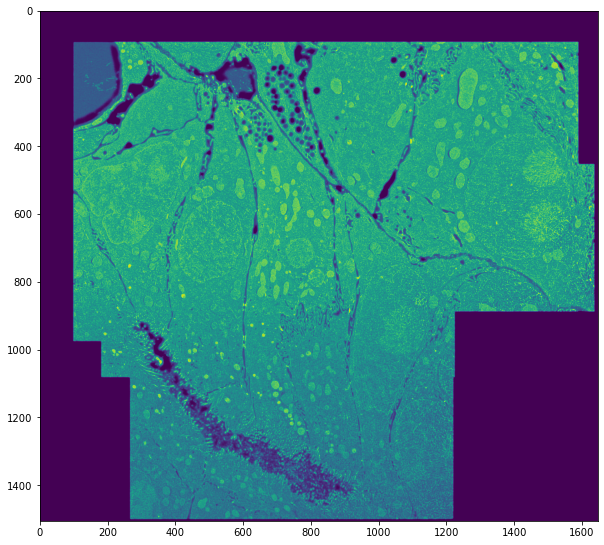

In [14]:
plt.imshow(raw[0, ...])

In [15]:
hmap = normalize_input(segmentations)
ws, _ = eseg.stacked_watershed(hmap, mask=fg_mask, n_threads=8, threshold=0.4, sigma_seeds=2.0)

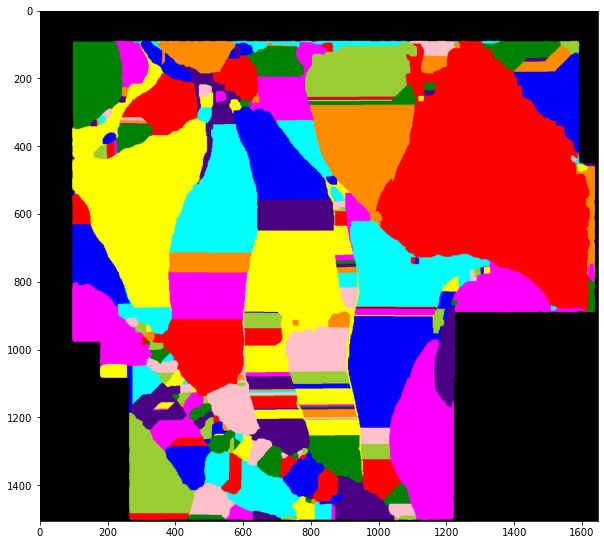

In [16]:
plt.imshow(label2rgb(ws[0, ...]))

In [17]:
seg = run_multicut(ws, hmap, beta=0.01)
seg[fg_mask] = seg[fg_mask] + 2
seg[segmentations > 0] = 1

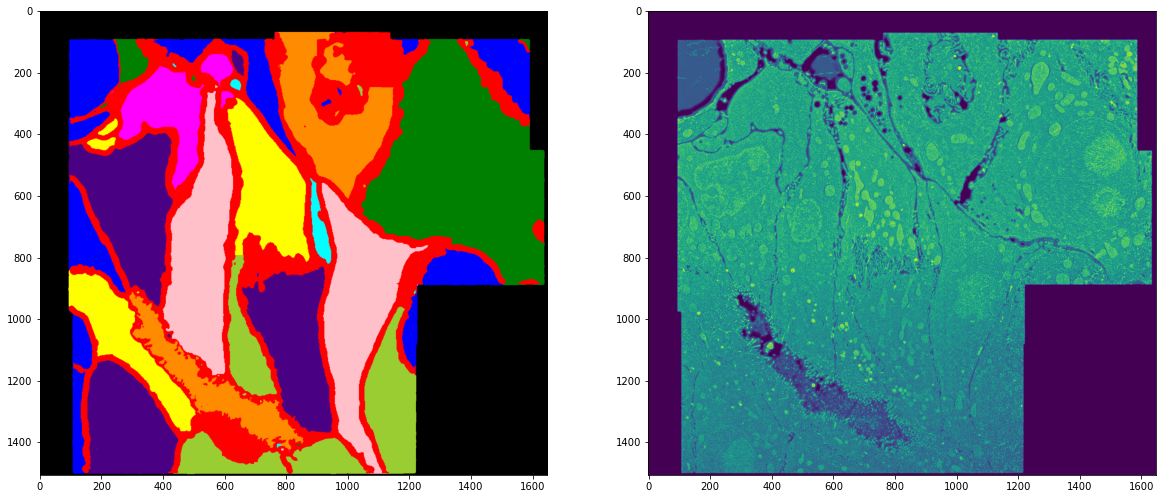

In [18]:
plt.figure(figsize=(20, 10))
i = 23
plt.subplot(121)
plt.imshow(label2rgb(seg[i, ...]))
plt.subplot(122)
plt.imshow(raw[i, ...])

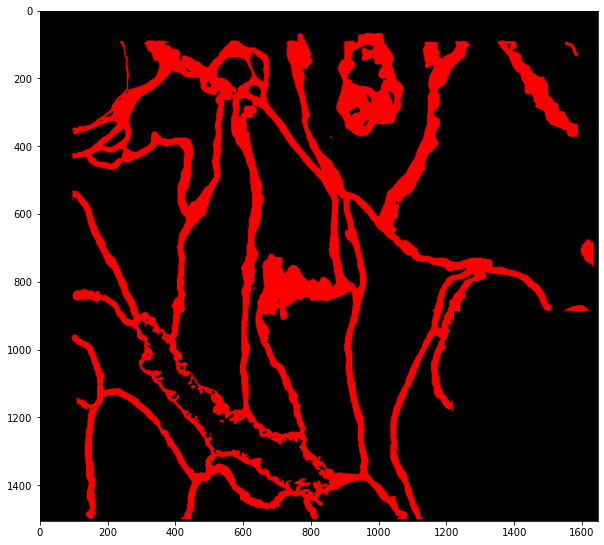

In [19]:
plt.imshow(label2rgb(segmentations[i, ...]))

In [20]:
import napari

In [21]:
v = napari.Viewer()

In [22]:
v.add_image(raw, name="raw")
v.add_labels(seg, name="seg")

<Labels layer 'seg' at 0x7fd1e22aa9b0>

In [24]:
extra_seg = v.layers["seg"].data

In [25]:
for fname, segm in zip(segmentation_files, extra_seg):
    print(output_dir / fname.name)
    imsave(output_dir / fname.name, segm.astype(np.uint16))

/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0280.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0281.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0282.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0283.tiff


/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0280.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0281.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0282.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0283.tiff is a low contrast image
  imsave(output_dir / fname.name, segm

/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0284.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0285.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0286.tiff


/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0284.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0285.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0286.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))


/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0287.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0288.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0289.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0290.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0291.tiff


/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0287.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0288.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0289.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0290.tiff is a low contrast image
  imsave(output_dir / fname.name, segm

/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0292.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0293.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0294.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0295.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0296.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0297.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0298.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0299.tiff


/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0292.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0293.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0294.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0295.tiff is a low contrast image
  imsave(output_dir / fname.name, segm

/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0300.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0301.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0302.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0303.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0304.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0305.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0306.tiff


/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0300.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0301.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0302.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0303.tiff is a low contrast image
  imsave(output_dir / fname.name, segm

/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0307.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0308.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0309.tiff
/g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0310.tiff


/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0307.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0308.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0309.tiff is a low contrast image
  imsave(output_dir / fname.name, segm.astype(np.uint16))
/tmp/ipykernel_1709/452943746.py:3: UserWarning: /g/kreshuk/buglakova/data/cryofib/raw/F107/em/F107_A1_gt_corrected/280_311_corrected/F107A1_additional_boundaries_0310.tiff is a low contrast image
  imsave(output_dir / fname.name, segm